# Direct methods for the numerical solution of linear systems

We are dealing with systems of linear equations, written in compact form using matrix-vector multiplications as 
$$ 
Ax=b,\quad 
\begin{array}{l}
	A\in\mathbb R^{n\times n}\\
	b\in \mathbb R^n\\
	x = (x_i)\in\mathbb R^n
\end{array}$$
where $A = (a_{i,j})$ is a given $n\times n$ matrix, the right-hand side ${b} = (b_i)$ is a given vector and ${x} = (x_j)$ is the unknown vector we want to determine. 
We know from linear algebra that if $\det \mathbf{A} \neq 0$, the systems admits a unique solution. 

Problems of this kind are ubiquitous in applied mathematics; it is therefore important to be able to solve them accurately and using as little computational resources as possible. 

By an algebraic viewpoint, a linear system is quite easy: the theory allows to determine existence and uniqueness of solutions and we know Cramer's rule that allows to compute the solution explicitly:
$$ 
x_k = \frac{\det B_k}{\det A} \quad k=1,\ldots,n\,,
$$
where $B_k$ is the matrix obtained by replacing the $k$-th column of $A$ with the known vector $b$. For example, if $k=2$:
$$
B_2 = \begin{bmatrix}a_{11} & \textcolor{red}{b_1}& \dots& a_{1n}\\
a_{21} & \textcolor{red}{b_2} &\dots& a_{2n}\\
\dots & \textcolor{red}{\dots}& \dots& \dots\\
a_{n1} & \textcolor{red}{b_n} &\dots& a_{nn}
\end{bmatrix}
$$
The problem comes when the size of the system $n$ becomes larger than $20$, as the computational cost of Cramer's algorithm scales like $(n+1)!$. This is totally unaffordable, let's see why.

In [1]:
import numpy as np
np.math.factorial(100)

93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000

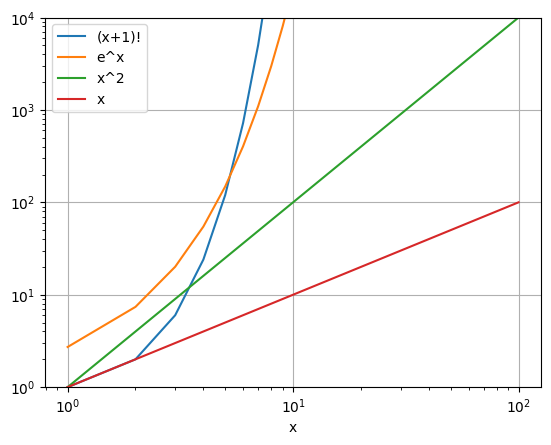

In [2]:
# let's plot the factorial function
import matplotlib.pyplot as plt
n = np.linspace(1, 100, 100)
n_fact = np.array([np.math.factorial(e) for e in n])
plt.loglog(n, n_fact, label=r"(x+1)!")
plt.loglog(n, np.exp(n), label=r"e^x")
plt.loglog(n, n**2, label=r"x^2")
plt.loglog(n, n, label=r"x")
plt.xlabel("x")
plt.legend()
plt.ylim(1, 1e4)
plt.grid()

What if we simplify the system into a *triangular* system? In that case the cost would be $n^2$! Let's recall the meaning of lower triangular and upper triangular matrices:
- $L$ lower triangular iff $l_{ij}=0$ for $i<j$;
- $U$ upper triangular iff $u_{ij}=0$ for $i>j$.

Solving a lower triangular system $Lx=b$ implies a *forward* substitution, while solving an upper triangular system $Ux=b$ implies a *backward* substitution formula.

## Gaussian elimination method

If we were able to factorize the matrix $A$ into a product 
$$ A = LU $$ 
with $L$ lower triangular and $U$ upper triangular, we could solve 
$$ 
LU x = b \implies
\left\{
\begin{array}{l}
	Ly = b \to \text{Forward substitution, $\mathcal{O}(n^2)$ flops} \\
	Ux = y \to \text{Backward substitution, $\mathcal{O}(n^2)$ flops}
\end{array}
\right.
$$

### Forward and backward substitution

#### Forward

$$
Ly = b \to 
\left\{
\begin{array}{l}
	l_{11}y_1 = b_1\\
	l_{21}y_1 + l_{22}y_2 = b_2\\
	\vdots \\
	l_{n1}y_1+l_{n2}y_2 + \cdots + l_{nn}y_n = b_n
\end{array}
\right.
$$


$$
\begin{array}{l}
y_{1} = \frac{b_1}{l_{11}} \\
y_{i} = \frac{1}{l_{ii}}(b_i - \sum_{j=1}^{i-1} l_{ij} y_j)
\end{array}
$$

In [3]:
# forward substitution
def L_solve(L, rhs):
    x = np.zeros_like(rhs)
    N = len(L)

    x[0] = rhs[0]/L[0, 0]
    for i in range(1, N):
        x[i] = (1/L[i, i]) * (rhs[i] - np.dot(L[i, :i], x[:i]))

    return x


#### Backward


$$
Ux = y \to 
\left\{
\begin{array}{l}
u_{11}x_1+\cdots + u_{n-1,n-1}x_{n-1} + u_{nn}x_n = y_n \\
\vdots \\
u_{n-1,n-1}x_{n-1} + u_{nn}x_n = y_{n-1}\\
u_{nn}x_n = y_n\\
\end{array}
\right.
$$


$$
\begin{array}{l}
x_n = \frac{y_n}{u_{nn}} \\
x_i = \frac{1}{u_{ii}} \left( y_i - \sum_{j=i+1}^{n} u_{ij}x_j \right)
\end{array}
$$

In [4]:
# backward substitution
def U_solve(U, rhs):
    x = np.zeros_like(rhs)
    N = len(U)

    x[-1] = rhs[-1]/U[-1, -1]
    for i in reversed(range(N-1)):
        x[i] = (1/U[i, i]) * (rhs[i] - np.dot(U[i, i+1:N], x[i+1:N]))

    return x

### Gaussian elimination algorithm

We use this method to transform the system $Ax=b$ into an upper triangular system $A'x={b}'$ with properly modified ${b}'$.

Given the matrix 
$$
A=
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\ 
a_{21} & a_{22} &  		 & a_{2n} \\ 
\vdots &  		& \ddots & \vdots \\ 
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{bmatrix}
$$
We start by eliminating all entries below $a_{11}$; this can be done by carefully subtracting entries of $A$ as follows: assuming $a_{11}\neq 0$, define 
$$l_{i1} = \frac{a_{i1}}{a_{11}}$$
and update the matrix
$$
a_{ij} \leftarrow a_{ij} - l_{i1} a_{1j},\quad{i,j=2,\ldots,n}.
$$

After this step we are left with a new matrix 
$$
A'=
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\ 
0 & a_{22}' &  		 & a_{2n}' \\ 
\vdots &  		& \ddots & \vdots \\ 
0 & a_{n2}' & \cdots & a_{nn}'
\end{bmatrix}
$$
Repeating the procedure $n-1$ times we get the desired factorization, because after the $n$-th transformation, $A'$ is upper triangular and the sequence of multipliers $l_{ik},\ i=k+1,\ldots,n$ defines a lower triangular matrix. So, in the end the Gaussian elimination method basically coincides with a LU factorization.

**Important** 
Of course, if we want to solve a linear system, all operations performed on $A$ need to be performed also on the right-hand side. 

So the general formulas are 
$$
\begin{array}{l}
	l_{ik} = \frac{a^{(k)}_{ik}}{a^{(k)}_{kk}},\quad i=k+1,\ldots,n \\
	a^{(k+1)}_{ij} = a^{(k)}_{ij} - l_{ik} a^{(k)}_{kj},\quad i,j= k+1,\ldots, n \\
	b_i^{(k+1)} = b_i^{(k)} - l_{ik} a^{(k)}_{kj},\quad i= k+1,\ldots, n.
\end{array}
$$

In [5]:
def LU(A):
    '''
    Implementation of Gaussian elimination method.
    '''
    A = A.copy()
    N = len(A)
    
    for k in range(N-1):
        if (abs(A[k, k]) < 1e-15):
            raise RuntimeError("Null pivot")

        A[k+1:N, k] /= A[k, k]
        for j in range(k+1, N):
            A[k+1:N, j] -= A[k+1:N, k] * A[k, j]

    L = np.tril(A)
    for i in range(N):
        L[i, i] = 1.0 # why is this necessary?

    U = np.triu(A)
    
    return L, U

## Application: Finite Differences solution of a boundary value problem
Let us consider the following boundary value problem 
$$
\left\{
\begin{array}{l}
	-u''(x) = f(x) \quad\text{in $(0,1)$} \\
	u(0) = u(1) = 0,
\end{array}
\right.
$$
which models an elastic string, which occupies at rest the space $[0,1]$ and is fixed at the two extremes. The unknown $u(x)$ represents the displacement of the string at the point $x$, and the right-hand side models a prescribed force $f(x)$ on the string.


For the numerical discretization of the problem, we consider a **Finite Difference (FD) Approximation**. Let $n$ be an integer, a consider a uniform subdivision of the interval $(0,1)$ using $n$ equispaced points, denoted by $\{x_i\}_{i=0}^n$ . Moreover, let $u_i$ be the FD approximation of $u(x_i)$, and similarly $f_i \approx f(x_i)$.

In order to formulate the discrete problem, we consider a FD approximation of the left-hand side, as follows:
$$
-u_{xx}(x_i) \approx \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2}
$$
being $h = \frac{1}{n-1}$ the size of each subinterval $(x_i, x_{i+1})$.

The problem that we need to solve is
$$
u_i = 0 \qquad\qquad\qquad\qquad i=0,
$$
$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad\qquad\qquad i=1, \ldots, n-1,\qquad\qquad\qquad(P)
$$
$$
u_i = 0 \qquad\qquad\qquad\qquad i=n.
$$

Then, let us collect al the unknowns $\{u_i\}_{i=0}^n$ in a vector $\mathbf{u}$. Then, (P) is a linear system
$$
A \mathbf{u} = \mathbf{f}.
$$

In [6]:
n = 30
h = 1/(n-1)

x = np.linspace(0, 1, n)

# define matrix A
a = - np.ones((n-1))
b = 2 * np.ones((n))
A = (1/h**2)*(np.diag(a, -1) + np.diag(b) + np.diag(a, 1))

# modify A to impose boundary conditions
A[0, :] = 0
A[:, 0] = 0
A[0, 0] = 1

A[-1, :] = 0
A[:, -1] = 0
A[-1, -1] = 1

### Forcing term and exact solution

If we set $f(x) = x(1-x)$, the exact solution of the problem is $u(x) = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$.

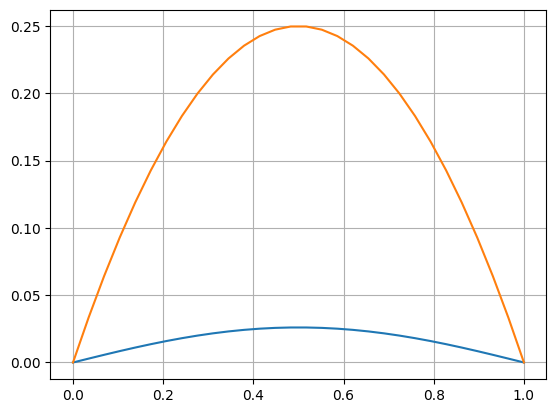

In [7]:
# forcing term
f = x * (1.-x)

# Exact solution 
u_ex = (x**4)/12. - (x**3)/6. + x/12.

plt.plot(x, u_ex)
plt.plot(x, f)
plt.grid()

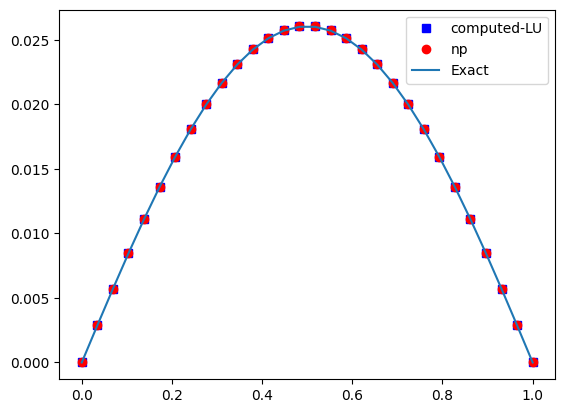

In [8]:
# solve the system using numpy
u = np.linalg.solve(A, f)

# LU factorization to solve the system
L, U = LU(A)
w = L_solve(L, f)
u_lu = U_solve(U, w)

# plot the exact solution, the numpy solution and the LU solution
plt.plot(x, u_lu, 'bs', label='computed-LU')
plt.plot(x, u, 'ro', label = 'np')
plt.plot(x, u_ex, label = 'Exact')
plt.legend()

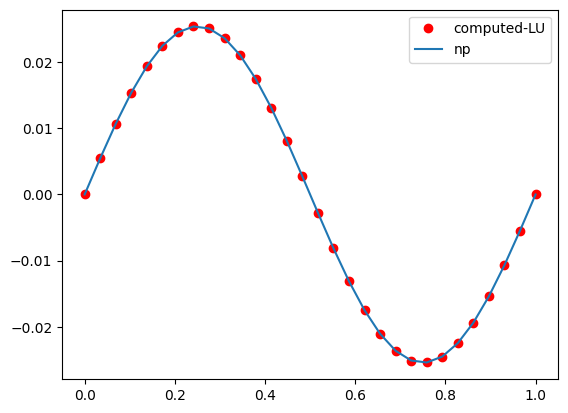

In [9]:
# try to compute the solution u for different forcing term and compare with the
# exact solution without recomputing the LU decomposition

f2 = np.sin(2*np.pi*x)

## YOUR CODE TO COMPUTE u_lu_new (hint: two lines are enough)
w_new = L_solve(L, f2)
u_lu_new = U_solve(U, w_new)

u_new = np.linalg.solve(A, f2)

plt.plot(x, u_lu_new, 'ro', label='computed-LU')
plt.plot(x, u_new, label='np')
plt.legend()

## Cholesky decomposition

In the case where the $n\times n$ matrix $A$ is symmetric and positive definite, there exists a unique upper triangular matrix
$R$ with positive diagonal elements such that
$$
A = R^T R,
$$
which is called _Cholesky decomposition_.

The entries of the matrix $R$ are computed as:
$$
\begin{array}{l}
	r_{11} = \sqrt{a_{11}} \\
	r_{ji} = \frac{1}{r_{jj}} \left( a_{ij} - \sum_{k=1}^{j-1} r_{ki}r_{kj} \right), j=1,\ldots, i-1 \\
	r_{ii} = \sqrt{a_{ii} - \sum_{k=1}^{i-1}r_{ki}^2}
\end{array}
$$

In [10]:
def cholesky(A):
    '''
    Define the Cholesky factorization.
    '''
    A = A.copy()
    N = len(A)
    ## what are we doing here?
    for k in range(N-1):
        A[k, k] = np.sqrt(A[k, k])
        A[k+1:N, k] = A[k+1:N, k]/A[k, k]

        for j in range(k+1, N):
            A[j:N, j] -= A[j:N, k] * A[j, k]

    A[-1, -1] = np.sqrt(A[-1, -1])
    L = np.tril(A) # we are computing a lower triangular matrix and not the upper triangular one, why?
    return L, L.transpose()

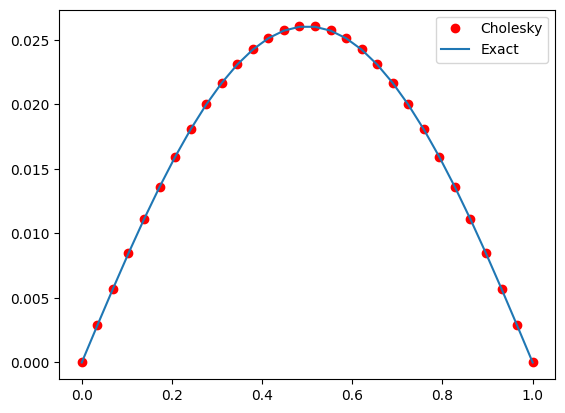

In [11]:
HT, H = cholesky(A)
y = L_solve(HT, f)
u = U_solve(H, y)

plt.plot(x, u, 'ro', label='Cholesky')
plt.plot(x, u_ex, label='Exact')
plt.legend()

## Gaussian algorithm with pivoting

All the implementations we have see so far assume that at each step $a^{(k)}_{kk} \neq 0$. 
But this is not always guaranteed, or easy to check before starting the elimination procedure. Only a handful of classes of matrices are known to have a $LU$ factorization for sure... 

To remedy, we can use the pivoting technique, which consists in exchanging rows (or columns) of the system so that no pivot is zero. 
This still does not guarantee that the algorithm finishes successfully, but it definitely enlarges the classes of matrices that can be factorized.

Moreover, we can rearrange the row (or columns) of the matrices, so that the pivot is always the biggest available number, so that the computation of the elimination matrices and the backward substitution, which involve a division by the pivots, are more numerically robust. 

We can have only changes of rows (*partial pivoting*) or changes of both rows and columns (*complete pivoting*). In particular:

- a change of rows corresponds to a multiplication by a permutation matrix on the left: $A \rightarrow PA$;
- a change of both rows and columns corresponds to a multiplication by a permutation matrix on the left and one on the right: $A \rightarrow PAQ$.

In this case, we won't have $A=LU$, but:
- $PA=LU$;
- or $PAQ=LU$,

where $P$ and $Q$ are combinations of different *permutation* matrices.

**Permutation matrices**

The matrix representing the application that swaps rows $i$ and $j$ of a column vector $x$ is obtained by swapping rows $i$ and $j$ of the identity matrix: 

In [12]:
def perm(i, j, n):
	'''
	Implementation of a permutation matrix
	'''

	P = np.eye(n)
	P[[i, j], :] = P[[j, i], :] ## take attention to this!

	return P

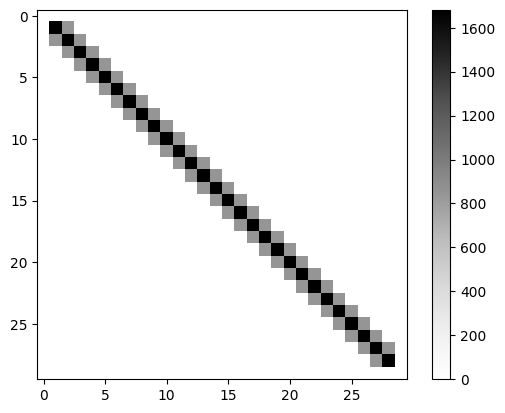

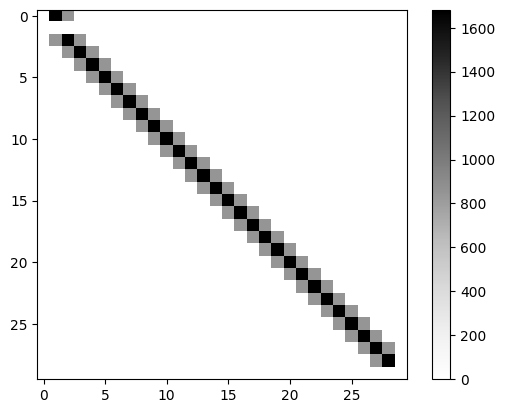

In [13]:
#print("Permute rows 1 and 2 of\n",A)
plt.imshow(np.abs(A), cmap="Greys")
plt.colorbar()
plt.show()
plt.imshow(np.abs(perm(0, 1, n)@A), cmap="Greys")
plt.colorbar()
plt.show()
#print("Result\n", perm(0, 1, n)@A)

We perform here an **LU factorization with partial pivoting**, i.e. we find matrices `( P, L, U )` such that $PA=LU$.

The algorithm proceeds column by column, performing three main operations at each step:

- 1. Pivot selection and permutation

At step $k$, we find the row `idmax` where the absolute value of the element in column $k$ (from row $k$ downward) is largest.
This ensures numerical stability by placing the largest available pivot on the diagonal.

A **permutation matrix** $P_k$ is then created to swap the current row $k$ with the pivot row `idmax`.
We update:

$$
U \leftarrow P_k U, \quad
P \leftarrow P_k P, \quad
L \leftarrow P_k L P_k,
$$

so that all matrices remain consistent with the row reordering.
- 2. Elimination below the pivot

Once the pivot is in place, we eliminate the entries below $u_{kk}$.
For each row $i>k$:

$$
L_{ik} = \frac{U_{ik}}{U_{kk}}, \quad
U_{i, k:} \leftarrow U_{i, k:} - L_{ik} U_{k, k:}.
$$

This stores the elimination multipliers in the lower part of $L$, while transforming $U$ toward upper-triangular form.
- 3. Completion of the decomposition

After processing all columns:

* $U$ is **upper triangular**.
* $L$ is **unit lower triangular** (with ones on the diagonal and the multipliers below it). It contains the elimination factors.
* $P$ records the **cumulative effect of all row swaps** (product of all permutation matrices $P_k$).

The final relationship produced by the algorithm is $PA=LU$.

We can then implement the algorithm:

In [14]:
def PALU(A):
    '''
    Implementation of LU decomposition with pivoting
    '''
    assert A.shape[1] == A.shape[0]
    n = A.shape[1]

    L = np.eye(n)
    P = np.eye(n)
    U = A.copy().astype(float)

    for k in range(n - 1):
        # Pivoting: find the index of the max element in column k (below or on the diagonal)
        idmax = np.argmax(abs(U[k:n, k])) + k

        # Permutation matrix for this step
        if idmax != k:
            Pk = perm(k, idmax, n)
            P = Pk @ P
            U = Pk @ U
            L = Pk @ L @ Pk  # Adjust L to keep consistency

        # Check for null pivot
        if abs(U[k, k]) < 1e-15:
            raise RuntimeError("Null pivot")

        # Elimination below the pivot
        for i in range(k + 1, n):
            factor = U[i, k] / U[k, k]
            U[i, k:] -= factor * U[k, k:]
            L[i, k] = factor

    return P, L, U

Let's apply the method to a test case where standard Gaussian elimination without pivoting cannot be applied.

In [15]:
A = np.array([
    [0., 2., 1.],
    [1., -2., -3.],
    [-1., 1., 0]
])
b = np.array([1., 2., 3.])
P, L, U = PALU(A)

print("A =\n", A)
print("\nP =\n", P)
print("\nL =\n", L)
print("\nU =\n", U)
print("\nCheck: PA = LU →", np.allclose(P @ A, L @ U))

# find x solution of Ax=b using the PALU decomposition
# LUx = Pb
# update b -> solve then Ly=Pb
Pb = P@b
# -> solve then Ly=Pb
y = L_solve(L, Pb)
# -> solve then Ux=y
x = U_solve(U, y)

# compare the solution with numpy
x_np = np.linalg.solve(A, b)
print(x_np, x)

A =
 [[ 0.  2.  1.]
 [ 1. -2. -3.]
 [-1.  1.  0.]]

P =
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

L =
 [[ 1.   0.   0. ]
 [ 0.   1.   0. ]
 [-1.  -0.5  1. ]]

U =
 [[ 1.  -2.  -3. ]
 [ 0.   2.   1. ]
 [ 0.   0.  -2.5]]

Check: PA = LU → True
[-1.4  1.6 -2.2] [-1.4  1.6 -2.2]


## Additional exercises
**Exercise 1.** Let us consider the linear system $A\mathbf{x} = \mathbf{b}$ where
$$
  A = 
  \begin{bmatrix}
  \epsilon & 1 & 2\\
  1 & 3 & 1 \\
  2 & 1 & 3 \\
  \end{bmatrix}.
$$

1. Find the range of values of $\epsilon \in \mathbb{R}$ such that the matrix $A$ is symmetric and positive definite.
**Suggestion**: use the *Sylvester's criterion* which states that  a symmetric matrix $A \in \mathbb{R}^{n \times n}$ is positive definite if and only if all the main minors (The main minors of $A \in \mathbb{R}^{n \times n}$ are the determinants of the submatrices $A_p = (a_{i,j})_{1 \leq i, j \leq p}$, $p = 1, ..., n$). of $A$ are positive.
2. What factorization is more suitable for solving the linear system $A\mathbf{x}=\mathbf{b}$ for the case $\epsilon=0$? Motivate the answer.
3. Compute the Cholesky factorization $A = R^T R$ for the case $\epsilon = 2$.
4. Given $\mathbf{b} = (1,1,1)^T$, solve the linear system by using the Cholesky factorization computed at the previous point.

**Exercise 2.** Let us consider the following matrix $A \in \mathbb R^{3 \times 3}$ depending on the parameter $\epsilon \in \mathbb R$:
$$
A =
\begin{bmatrix}
1 & \epsilon & -1 \\
\epsilon & \frac{35}3 & 1 \\
-1 & \epsilon & 2 \\
\end{bmatrix}.
$$



1. Calculate the values of the parameter $\epsilon \in \mathbb R$ for which the matrix $A$ is invertible (non singular).

2. Calculate the Gauss factorization $LU$ of the matrix $A$ (when non singular) for a generic value of the parameter $\epsilon \in \mathbb R$.

3. Calculate the values of the parameter $\epsilon \in \mathbb R$ for which the Gauss factorization $LU$ of the matrix $A$  (when non singular) exists and is unique.

4. Set $\epsilon = \sqrt{\frac{35}3}$ and use the pivoting technique to calculate the Gauss factorization $LU$ of the matrix $A$.

5. For $\epsilon=1$, the matrix $A$ is symmetric and positive definite. Calculate the corresponding Cholesky factorization of the matrix $A$, i.e. the upper triangular matrix with positive elements on the diagonal, say $R$, for which $A = R^T R$.

**Ex. 1 - solution**

In [16]:
import numpy as np

# 1 .
def A_ex1(eps):
    return np.array([
        [eps, 1, 2],
        [1, 3, 1],
        [2, 1, 3]
    ], dtype=float)

# Sylvester criterion
def sylvester_criterion(eps):
    A = A_ex1(eps)
    minors = [
        np.linalg.det(A[:1,:1]),
        np.linalg.det(A[:2,:2]),
        np.linalg.det(A)
    ]
    return minors

for eps in [0.5, 1, 1.4, 2]:
    minors = sylvester_criterion(eps)
    print(f"eps={eps:.2f} -> main minors: {minors}")

eps=0.50 -> main minors: [0.5, 0.5, -7.000000000000001]
eps=1.00 -> main minors: [1.0, 2.0, -3.0000000000000004]
eps=1.40 -> main minors: [1.4, 3.2, 0.19999999999999926]
eps=2.00 -> main minors: [2.0, 5.000000000000001, 5.000000000000001]


In [20]:
# 2. 
A0 = A_ex1(0)
print("A(0) =\n", A0)

# Cholesky fails
try:
    L = cholesky(A0)
except Exception as e:
    print("Cholesky not applicable:", e)

# use PALU
P, L, U = PALU(A0)
print("P =\n", P)
print("L =\n", L)
print("U =\n", U)

A(0) =
 [[0. 1. 2.]
 [1. 3. 1.]
 [2. 1. 3.]]
P =
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
L =
 [[1.  0.  0. ]
 [0.5 1.  0. ]
 [0.  0.4 1. ]]
U =
 [[ 2.   1.   3. ]
 [ 0.   2.5 -0.5]
 [ 0.   0.   2.2]]


/var/folders/20/mz3xqzgx7kj1tndphz__vgzm0000gn/T/ipykernel_88788/2914764139.py:10: RuntimeWarning: divide by zero encountered in divide
  A[k+1:N, k] = A[k+1:N, k]/A[k, k]
/var/folders/20/mz3xqzgx7kj1tndphz__vgzm0000gn/T/ipykernel_88788/2914764139.py:9: RuntimeWarning: invalid value encountered in sqrt
  A[k, k] = np.sqrt(A[k, k])


In [22]:
# 3.
eps = 2
A = A_ex1(eps)
print("A(2) =\n", A)

L, LT = cholesky(A)
print("L (Cholesky):\n", L)

# Check that A = L @ L.T
print("Verify:\n", L @ LT)

A(2) =
 [[2. 1. 2.]
 [1. 3. 1.]
 [2. 1. 3.]]
L (Cholesky):
 [[1.41421356e+00 0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 1.58113883e+00 0.00000000e+00]
 [1.41421356e+00 1.40433339e-16 1.00000000e+00]]
Verify:
 [[2. 1. 2.]
 [1. 3. 1.]
 [2. 1. 3.]]


In [23]:
# 4.
b = np.array([1,1,1], dtype=float)

# Solve Ly=b
y = L_solve(L, b)

# Solve Ux = y, with U = L^T
x = U_solve(L.T, y)

print("Solution x =", x)

Solution x = [4.00000000e-01 2.00000000e-01 2.22044605e-16]
